In [1]:
# import libraries
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from scraper import load_chrome_driver,get_distillation_temps

# set driver module
driver = load_chrome_driver()

[WDM] - Current google-chrome version is 87.0.4280
[WDM] - Get LATEST driver version for 87.0.4280
[WDM] - Driver [C:\Users\adams\.wdm\drivers\chromedriver\win32\87.0.4280.88\chromedriver.exe] found in cache
 


In [2]:

# retrieve the oil profile function given a temperature table, the function is a 3rd degree polynomial
def get_oil_profile_func(temp_tbl):
    try:
        return np.poly1d(np.polyfit(temp_tbl.index, temp_tbl.values, 3))
    except:
        return "**Error: Invalid input, provided parameter is not a pd.Series object**"


# creates an oil mixture profile function given 2 different oil lists 
def mixed_oil_distillation(oil_temps_a, oil_temps_b):
    percent_yield = [5,10,20,30,40,50,60,70,80,90,95,99]
    mixture_temps = []
    
    try:
        # iterate thorugh both oil lists and append the approximate value to a new temperature list (mixture_temps)
        for i in range(12):
            approx_val = (oil_temps_a[i] + oil_temps_b[i]) / 2

            # if the approx_val does not exist, pop the last value of the percent yield list
            if np.isnan(approx_val):
                percent_yield.pop()
            else:
                mixture_temps.append(approx_val)
        mixture_tbl = pd.Series(data=mixture_temps, index=percent_yield)
        return get_oil_profile_func(mixture_tbl)
   
    except:
        return "**Error: Invalid temperature lists were provided**"


# returns the temperature needed to retrieve the volume given an oil profile function
def oil_snapshot(oil_profile_func, percent):
    try:
        # checks to see if the percentage is within range [5,99]
        if percent >= 5 and percent <= 99:
            return int(oil_profile_func(percent))
        else:
            return "**Error: Percentage not within range**"
    except:
        return "**Error: Oil profile function is invalid**"


# returns a the profile table of the mixture, with preset temperatures
def oil_snapshot_tbl(oil_profile_func):
    percent_yield = [5,10,20,30,40,50,60,70,80,90,95,99]
    oil_temps = []
    try:
        for i in range(12):
            oil_temps.append(oil_snapshot(oil_profile_func,percent_yield[i]))
        return pd.Series(data=oil_temps, index=percent_yield)
    except:
        return "**Error: Oil profile function is invalid**"


In [3]:
# Test Cases

url_a = 'https://www.crudemonitor.ca/crudes/dist.php?acr=MSY&time=recent' #valid link
url_b = 'https://www.crudemonitor.ca/crudes/dist.php?acr=MSW&time=recent' #valid link
url_c = 'https://www.crudemonitor.ca/condensates/index.php?acr=CPM' #invalid link

# Testing Selenium Scraper Module
def test_scraper():
    print("\n--Scraper Testing--")

    oil_temps_a = get_distillation_temps(driver, url_a)
    print("\nTest 1:")
    print(oil_temps_a)

    oil_temps_b = get_distillation_temps(driver, url_b)
    print("\nTest 2:")
    print(oil_temps_b)

    oil_temps_c = get_distillation_temps(driver, url_c)
    print("\nTest 3:")
    print(oil_temps_c)


# Testing Mixed Oil Distillation Module
def test_mixed_oil_distillation():
    print("\n--Mixed Oil Distillation Testing--")
    oil_temps_a = get_distillation_temps(driver, url_a)
    oil_temps_b = get_distillation_temps(driver, url_b)
    oil_temps_c = get_distillation_temps(driver, url_c)

    # When invalid parameters are provided
    model_1 = mixed_oil_distillation(oil_temps_a,oil_temps_c)
    print("\nTest 1:")
    print(model_1)

    # When valid parameters are provided
    model_2 = mixed_oil_distillation(oil_temps_a,oil_temps_b)
    print("\nTest 2:")
    print(model_2)


# Testing Get Oil Profile Function Module
def test_get_oil_profile_func():
    print("\n--Oil Profile Function Testing--")

    oil_temps_a = get_distillation_temps(driver, url_a)
    percent_yield = [5,10,20,30,40,50,60,70,80,90,95,99]
    oil_a_tbl = pd.Series(data=oil_temps_a, index=percent_yield)

    # When there are NaN values in the series
    print("\nTest 1:")
    model_1 = get_oil_profile_func(oil_a_tbl)
    print(model_1)

    # When passed parameter isn't a series function
    print("\nTest 2:")
    oil_a_dict = {percent_yield[i]: oil_temps_a[i] for i in range(len(percent_yield))} 
    model_2 = get_oil_profile_func(oil_a_dict)
    print(model_2)

    # When a correct series object (without NaN) is provided 
    print("\nTest 3:")
    # in this case we will remove the last values for temps_list and percent_yield so there are no NaN values
    percent_yield.pop()
    oil_temps_a.pop()
    oil_a_tbl = pd.Series(data=oil_temps_a, index=percent_yield)
    model_3 = get_oil_profile_func(oil_a_tbl)
    print(model_3)


# Testing Get Oil Snapshot Table Module
def test_oil_snapshot_tbl():
    print("\n--Oil Snapshot Table Testing--")

    oil_temps_a = get_distillation_temps(driver, url_a)
    oil_temps_b = get_distillation_temps(driver, url_b)
  
    # When a invalid regression function is provided
    print("\nTest 1:")
    model_1 = []
    snapshot_tbl_1 = oil_snapshot_tbl(model_1)
    print(snapshot_tbl_1)

    # When a valid regression function is provided
    print("\nTest 2:")
    model_2 = mixed_oil_distillation(oil_temps_a,oil_temps_b)
    snapshot_tbl_2 = oil_snapshot_tbl(model_2)
    print(snapshot_tbl_2)


# Testing Oil Snapshot Module
def test_oil_snapshot():
    print("\n--Oil Snapshot Testing--")

    oil_temps_a = get_distillation_temps(driver, url_a)
    oil_temps_b = get_distillation_temps(driver, url_b)
   
    # When an invalid model is provided
    print("\nTest 1:")
    model_1 = []
    snapshot_1 = oil_snapshot(model_1,75)
    print(snapshot_1)

    # When an invalid percentage is provided
    print("\nTest 2:")
    model_2 = []
    snapshot_2 = oil_snapshot(model_2,110)
    print(snapshot_2)

    #When a valid model and percentage are provided
    print("\nTest 3:")
    model_3 = mixed_oil_distillation(oil_temps_a,oil_temps_b)
    snapshot_3 = oil_snapshot(model_3,75)
    print(snapshot_3)

test_scraper()
test_mixed_oil_distillation()
test_get_oil_profile_func()
test_oil_snapshot_tbl()
test_oil_snapshot()


--Scraper Testing--

Test 1:
[52.8, 111.3, 170.2, 229.0, 283.2, 333.7, 390.6, 448.0, 517.9, 622.7, 705.3, nan]

Test 2:
[62.3, 101.9, 140.2, 197.4, 255.7, 312.8, 372.9, 436.7, 513.5, 638.0, nan, nan]

Test 3:
**Error: invalid url or invalid driver module**

--Mixed Oil Distillation Testing--

Test 1:
**Error: Invalid temperature lists were provided**

Test 2:
           3           2
0.0007788 x - 0.09069 x + 8.579 x + 20.17

--Oil Profile Function Testing--

Test 1:
     3       2
nan x + nan x + nan x + nan

Test 2:
**Error: Invalid input, provided parameter is not a pd.Series object**

Test 3:
          3          2
0.001121 x - 0.1458 x + 11.01 x + 4.968

--Oil Snapshot Table Testing--

Test 1:
5     **Error: Oil profile function is invalid**
10    **Error: Oil profile function is invalid**
20    **Error: Oil profile function is invalid**
30    **Error: Oil profile function is invalid**
40    **Error: Oil profile function is invalid**
50    **Error: Oil profile function is invalid


The temperature needs to be '500 deg C' to retrieve '75%' of oil volume.


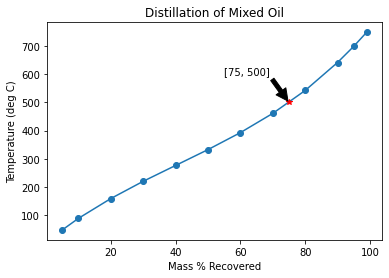


--Distillation Table of Mixed Oil--
                  Temperatures
Mass % Recovered              
5                           49
10                          90
20                         160
30                         221
40                         277
50                         333
60                         393
70                         461
80                         542
90                         641
95                         698
99                         748


In [4]:
# Application that runs the Crude Oil Distillation Analysis, and displays a plot of the results 
def app(url_oil_a,url_oil_b,percentage):
    if percentage < 5 or percentage > 99:
        print("**Error: Percentage was no within range of 5-99**")
    else:
        try:
            oil_temps_a = get_distillation_temps(driver,url_oil_a)
            oil_temps_b = get_distillation_temps(driver,url_oil_b)
            mixed_oil_func = mixed_oil_distillation(oil_temps_a,oil_temps_b)
            mixed_oil_snapshot_tbl = oil_snapshot_tbl(mixed_oil_func)
            mixed_oil_snapshot_temp = oil_snapshot(mixed_oil_func,percentage)
            plt.scatter(mixed_oil_snapshot_tbl.index,mixed_oil_snapshot_tbl.values)
            plt.plot(mixed_oil_snapshot_tbl.index,mixed_oil_snapshot_tbl.values)
            plt.plot(percentage,mixed_oil_snapshot_temp, 'r*')
            plt.annotate(str([percentage,mixed_oil_snapshot_temp]), xy=(percentage, mixed_oil_snapshot_temp), xytext=(percentage-20, mixed_oil_snapshot_temp+100),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    )
            plt.title("Distillation of Mixed Oil")
            plt.ylabel('Temperature (deg C)')
            plt.xlabel('Mass % Recovered')
            print("\nThe temperature needs to be '" + str(mixed_oil_snapshot_temp) + " deg C' to retrieve '" + str(percentage) +"%' of oil volume.")
            plt.show()
            print("\n--Distillation Table of Mixed Oil--")
            mixed_oil_snapshot_tbl.name = "Temperatures"
            mixed_oil_snapshot_tbl.index.name = "Mass % Recovered"
            print(pd.DataFrame(mixed_oil_snapshot_tbl))
        except:
            print("**Error: Invalid url links passed**")


# USER INPUT:
# Please copy and paste the distillation urls for the crude oils that you would like to mix, as well as the percent of volume you wish recover
url_a = 'https://www.crudemonitor.ca/crudes/dist.php?acr=PCH&time=recent'  
url_b = 'https://www.crudemonitor.ca/crudes/dist.php?acr=MPR&time=recent' 
percentage = 88

app(url_a,url_b,percentage)